# Hotel Booking Cancelation Classification - Cleaning & EDA
**By: Sarah Alabdulwahab & Asma Althakafi**
> Our goal is to classify the customers that will cancel their hotel booking and those that will not.

> In addition, we aim to perform 3 experiments:
1. Fit the models on the data after cleaning.
2. Fit the models on the data without outliers.
3. Fit the models on the data with feature selection methods.

## Data Description 
> This dataset contains booking information for a city hotel and a resort hotel, and includes information such as when the booking was made, length of stay, the number of adults, children, and/or babies, and the number of available parking spaces, among other things.

In [160]:
# supress warnings
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# data manipulation imports
import pandas as pd
import numpy as np
import re

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# web scraping imports
import requests
from bs4 import BeautifulSoup

## Hotel Booking Data

In [161]:
bookings_df = pd.read_csv("hotel_bookings.csv")
bookings_df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [162]:
print('The dataset contains',bookings_df.shape[0],'observations and',bookings_df.shape[1],'features')

The dataset contains 119390 observations and 32 features


In [163]:
bookings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

### Cleaning

In [164]:
#check for nulls
bookings_df.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [165]:
#Since company and agent have too many null values, we decided to drop them.
bookings_df.drop(columns=['company','agent'], inplace=True)

In [166]:
#drop nulls
bookings_df.dropna(inplace=True)

In [167]:
#check for duplicated rows
bookings_df.duplicated().sum()

31984

In [168]:
#remove duplicated rows but only keep the first occurance
bookings_df.drop_duplicates(keep="first",inplace=True) 

In [169]:
#reseting the index after dropping
bookings_df.reset_index(drop=True, inplace=True)

In [170]:
print('After cleaning, the dataset contains',bookings_df.shape[0],'observations and',bookings_df.shape[1],'features')

After cleaning, the dataset contains 86914 observations and 30 features


### Discovering the Features

**The numerical features**

In [171]:
num_features = list(bookings_df.select_dtypes(include= ['int64', 'float64']).columns)
print(num_features)

['is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces', 'total_of_special_requests']


In [172]:
print('There are',len(num_features),'numerical features')

There are 18 numerical features


**`lead_time`**: Number of days that elapsed between the entering date of the booking into the PMS and the arrival date.

In [173]:
#number of unique values
bookings_df.lead_time.nunique()

479

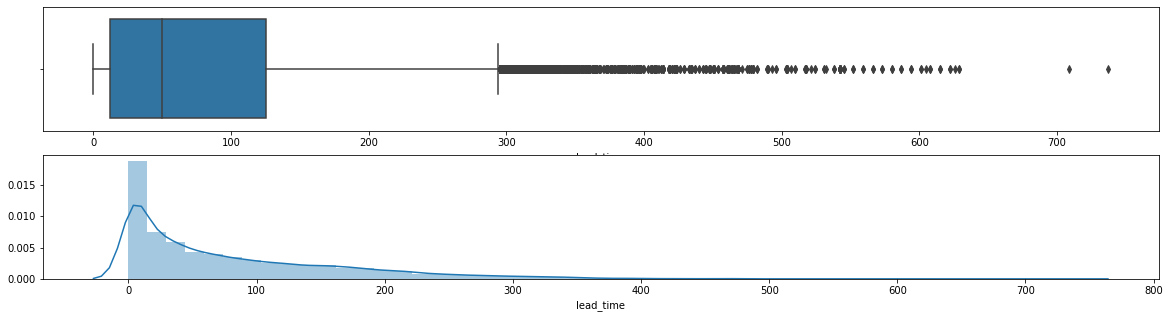

In [174]:
fig, axs = plt.subplots(2, figsize=(20,5))
sns.boxplot("lead_time", data=bookings_df, ax=axs[0]);
sns.distplot(bookings_df['lead_time'], ax=axs[1]);

In [175]:
#5 most occurring values
bookings_df.lead_time.value_counts().head()

0    5857
1    3148
2    1889
3    1689
4    1551
Name: lead_time, dtype: int64

In [176]:
#5 least occurring values
bookings_df.lead_time.value_counts().tail()

458    1
507    1
709    1
400    1
424    1
Name: lead_time, dtype: int64

In [177]:
#remove the outliers
Q1 = bookings_df['lead_time'].quantile(0.25)
Q3 = bookings_df['lead_time'].quantile(0.75)
IQR = Q3 - Q1 
bookings_df_no_outliers = bookings_df.loc[(bookings_df['lead_time'] >= Q1 - 1.5 * IQR) & 
                                          (bookings_df['lead_time'] <= Q3 + 1.5 *IQR)]

**`arrival_date_year`**: Year of arrival date.

In [178]:
#number of unique values
bookings_df.arrival_date_year.nunique()

3

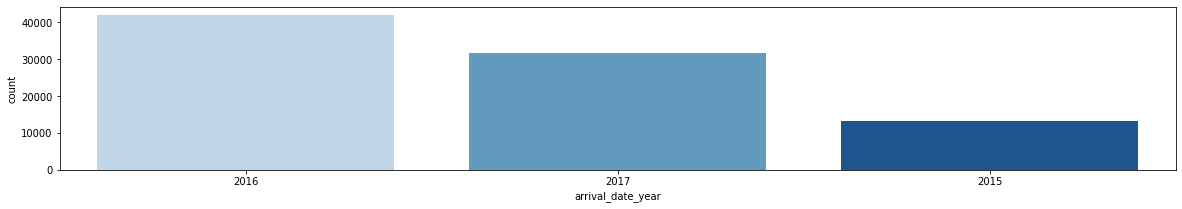

In [179]:
plt.figure(figsize=(20,3))
sns.countplot(bookings_df['arrival_date_year'], palette = sns.color_palette("Blues")[1::2], 
              order = bookings_df['arrival_date_year'].value_counts().index);

In [180]:
#occurrance of values
bookings_df.arrival_date_year.value_counts()

2016    42114
2017    31606
2015    13194
Name: arrival_date_year, dtype: int64

**`arrival_date_week_number`**: Week number of year for arrival date.

In [181]:
#number of unique values
bookings_df.arrival_date_week_number.nunique()

53

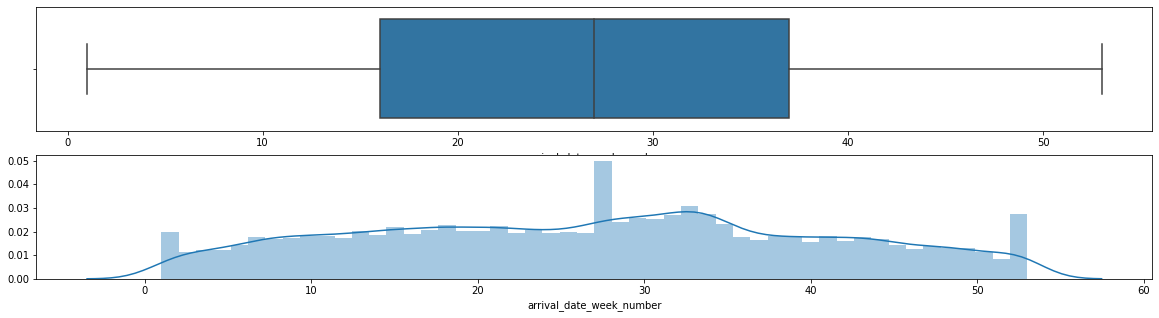

In [182]:
fig, axs = plt.subplots(2, figsize=(20,5))
sns.boxplot("arrival_date_week_number", data=bookings_df, ax=axs[0]);
sns.distplot(bookings_df['arrival_date_week_number'], ax=axs[1]);

In [183]:
#5 most occurring values
bookings_df.arrival_date_week_number.value_counts().head()

33    2784
34    2488
32    2442
28    2335
30    2326
Name: arrival_date_week_number, dtype: int64

In [184]:
#5 least occurring values
bookings_df.arrival_date_week_number.value_counts().tail()

50    1043
3     1030
2      939
1      859
51     767
Name: arrival_date_week_number, dtype: int64

**`arrival_date_day_of_month`**: Day of arrival date.

In [185]:
#number of unique values
bookings_df.arrival_date_day_of_month.nunique()

31

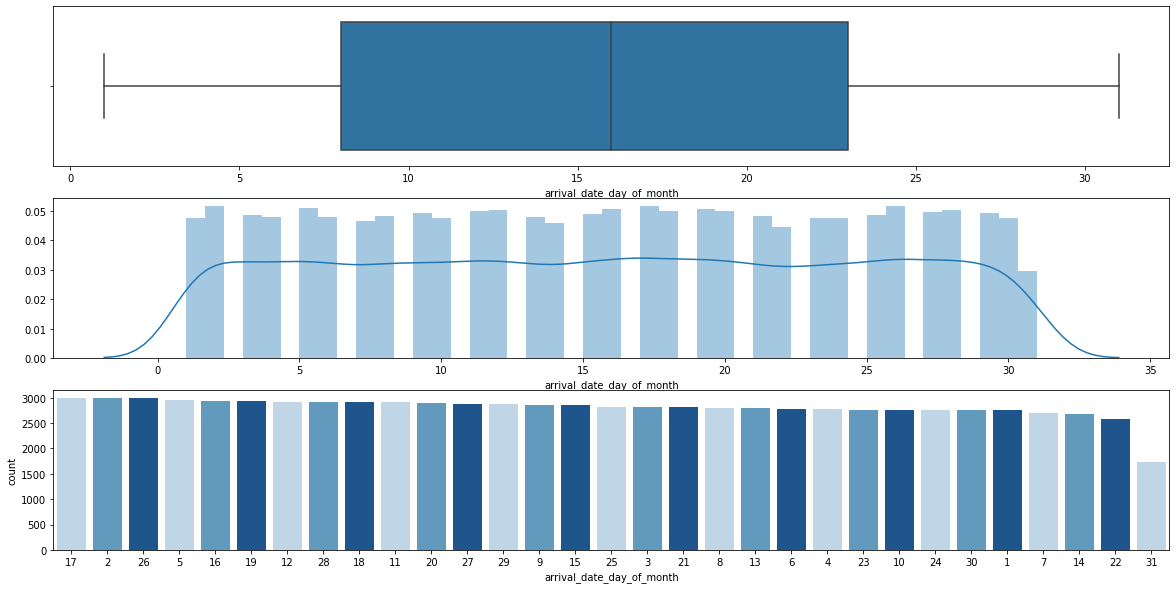

In [186]:
fig, axs = plt.subplots(3, figsize=(20,10))
sns.boxplot("arrival_date_day_of_month", data=bookings_df, ax=axs[0]);
sns.distplot(bookings_df['arrival_date_day_of_month'], ax=axs[1]);
sns.countplot(bookings_df['arrival_date_day_of_month'], palette = sns.color_palette("Blues")[1::2], 
              order = bookings_df['arrival_date_day_of_month'].value_counts().index, ax = axs[2]);

In [187]:
#5 most occurring values
bookings_df.arrival_date_day_of_month.value_counts().head()

17    3002
2     2997
26    2990
5     2965
16    2939
Name: arrival_date_day_of_month, dtype: int64

In [188]:
#5 least occurring values
bookings_df.arrival_date_day_of_month.value_counts().tail()

1     2753
7     2694
14    2672
22    2589
31    1724
Name: arrival_date_day_of_month, dtype: int64

**`stays_in_weekend_nights`**: Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel.

In [189]:
#number of unique values
bookings_df.stays_in_weekend_nights.nunique()

15

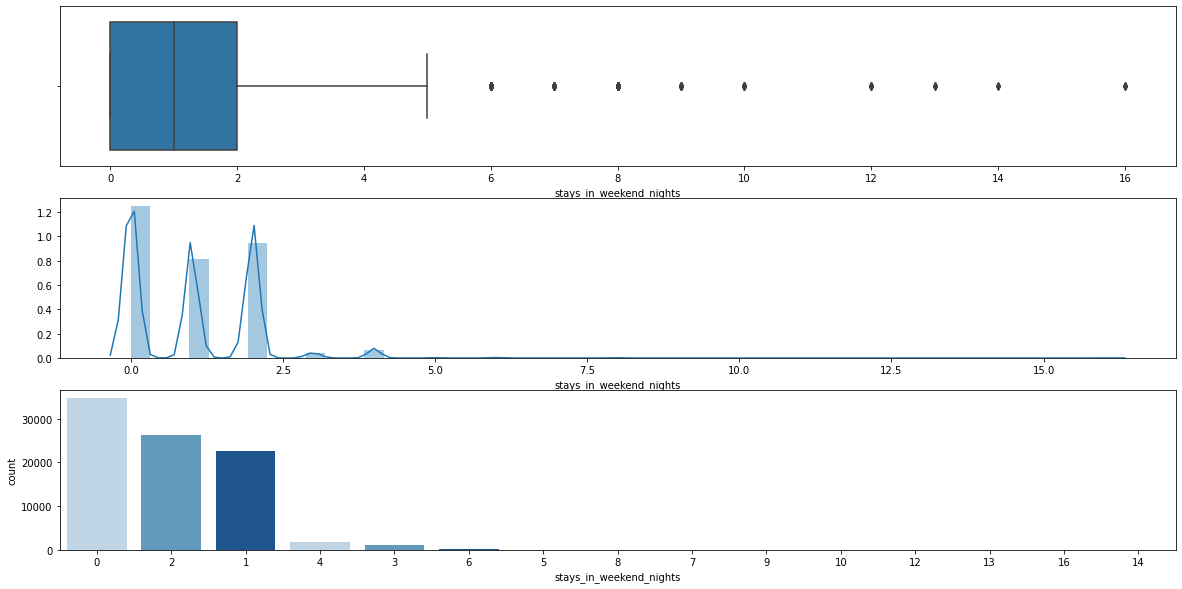

In [190]:
fig, axs = plt.subplots(3, figsize=(20,10))
sns.boxplot("stays_in_weekend_nights", data=bookings_df, ax=axs[0]);
sns.distplot(bookings_df['stays_in_weekend_nights'], ax=axs[1]);
sns.countplot(bookings_df['stays_in_weekend_nights'], palette = sns.color_palette("Blues")[1::2], 
              order = bookings_df['stays_in_weekend_nights'].value_counts().index, ax = axs[2]);

In [191]:
#5 most occurring values
bookings_df.stays_in_weekend_nights.value_counts().head()

0    34839
2    26367
1    22549
4     1728
3     1144
Name: stays_in_weekend_nights, dtype: int64

In [192]:
#5 least occurring values
bookings_df.stays_in_weekend_nights.value_counts().tail()

10    7
12    5
13    3
16    3
14    2
Name: stays_in_weekend_nights, dtype: int64

In [193]:
#remove the outliers
bookings_df_no_outliers = bookings_df_no_outliers[(bookings_df_no_outliers['stays_in_weekend_nights'] >= 0) & 
                                                  (bookings_df_no_outliers['stays_in_weekend_nights'] <= 10)]

**`stays_in_week_nights`**: Number of weeknights (Monday to Friday) the guest stayed or booked to stay at the hotel.

In [194]:
#number of unique values
bookings_df.stays_in_week_nights.nunique()

33

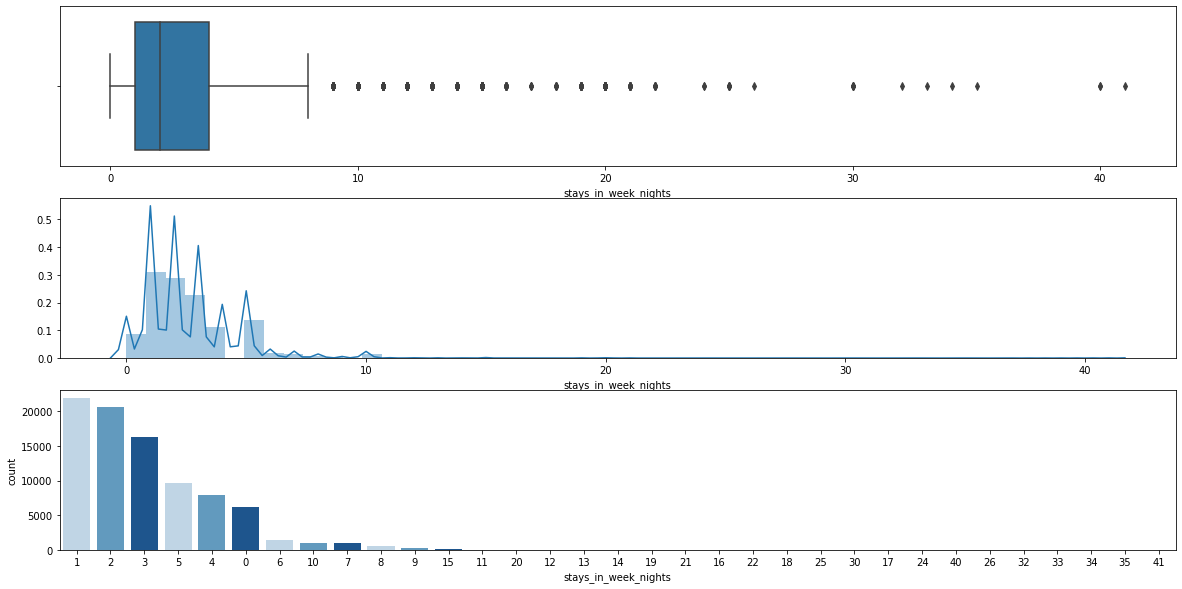

In [195]:
fig, axs = plt.subplots(3, figsize=(20,10))
sns.boxplot("stays_in_week_nights", data=bookings_df, ax=axs[0]);
sns.distplot(bookings_df['stays_in_week_nights'], ax=axs[1]);
sns.countplot(bookings_df['stays_in_week_nights'], palette = sns.color_palette("Blues")[1::2], 
              order = bookings_df['stays_in_week_nights'].value_counts().index, ax = axs[2]);

In [196]:
#5 most occurring values
bookings_df.stays_in_week_nights.value_counts().head()

1    21964
2    20633
3    16215
5     9645
4     7863
Name: stays_in_week_nights, dtype: int64

In [197]:
#5 least occurring values
bookings_df.stays_in_week_nights.value_counts().tail()

32    1
33    1
34    1
35    1
41    1
Name: stays_in_week_nights, dtype: int64

In [198]:
#remove the outliers
bookings_df_no_outliers = bookings_df_no_outliers[(bookings_df_no_outliers['stays_in_week_nights'] >= 0) &
                                                  (bookings_df_no_outliers['stays_in_week_nights'] <= 20)]

**`adults`**: Number of adults.

In [199]:
#number of unique values
bookings_df.adults.nunique()

14

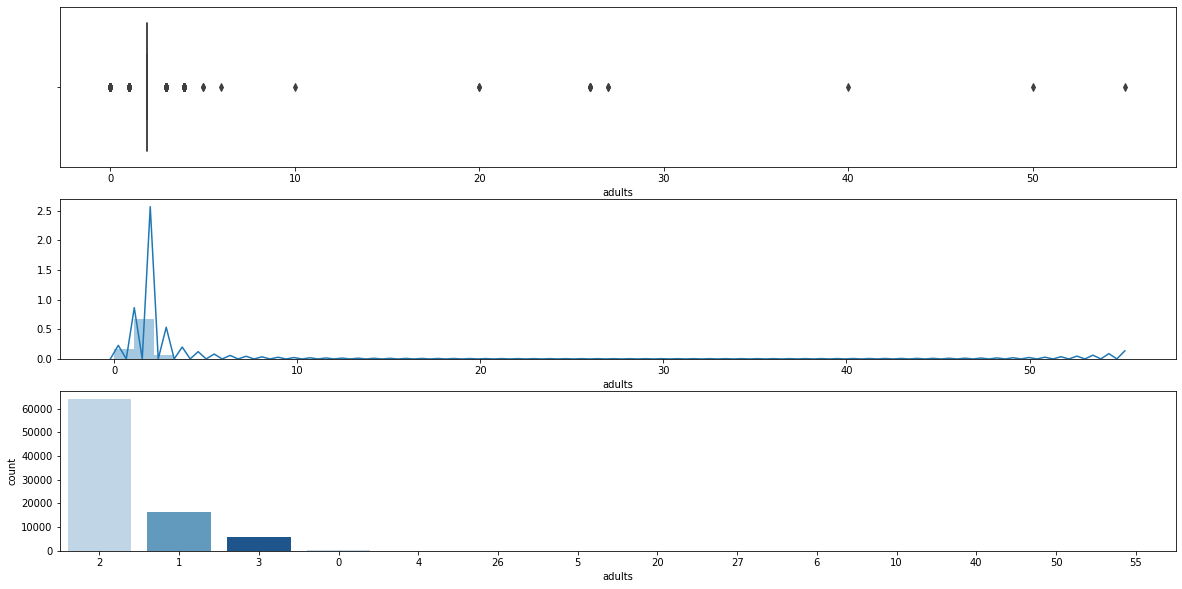

In [200]:
fig, axs = plt.subplots(3, figsize=(20,10))
sns.boxplot("adults", data=bookings_df, ax=axs[0]);
sns.distplot(bookings_df['adults'], ax=axs[1]);
sns.countplot(bookings_df['adults'], palette = sns.color_palette("Blues")[1::2], 
              order = bookings_df['adults'].value_counts().index, ax = axs[2]);

In [201]:
#5 most occurring values
bookings_df.adults.value_counts().head()

2    64324
1    16204
3     5930
0      380
4       60
Name: adults, dtype: int64

In [202]:
#5 least occurring values
bookings_df.adults.value_counts().tail()

6     1
10    1
40    1
50    1
55    1
Name: adults, dtype: int64

It seems like there is a mistake in the adults feature, as 0 adults makes no sense. Therefore, we will exclude this from the main dataframe.

In [203]:
bookings_df = bookings_df[bookings_df.adults > 0]

In [204]:
#remove the outliers
bookings_df_no_outliers = bookings_df_no_outliers[(bookings_df_no_outliers.adults > 0) &
                                                  (bookings_df_no_outliers.adults <= 4)]

**`children`**: Number of children.

In [205]:
#number of unique values
bookings_df.children.nunique()

5

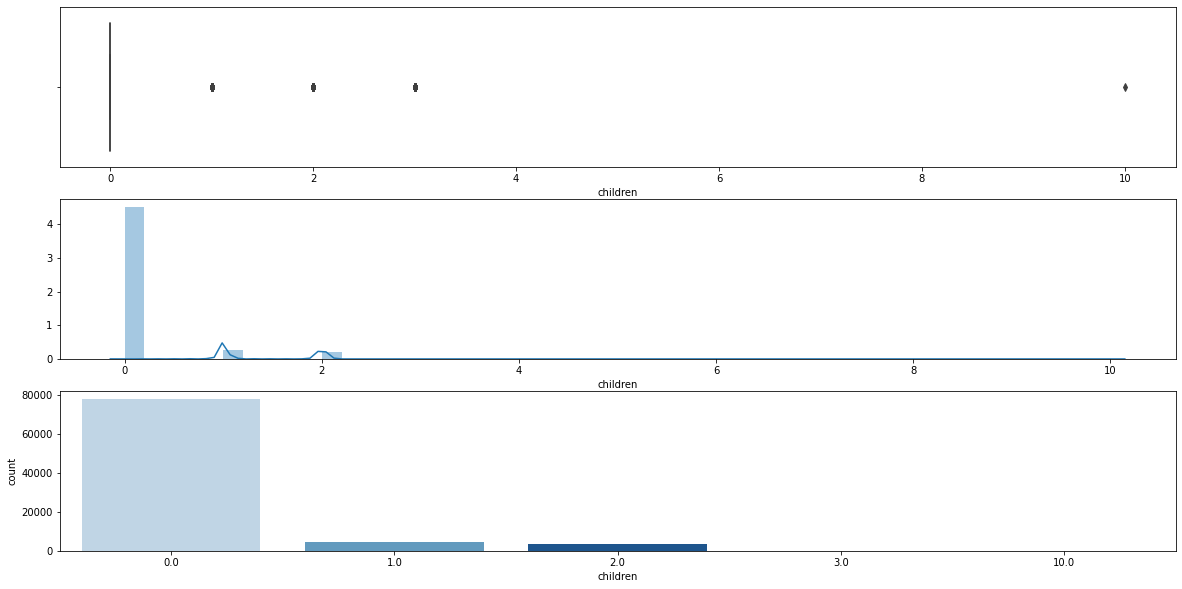

In [206]:
fig, axs = plt.subplots(3, figsize=(20,10))
sns.boxplot("children", data=bookings_df, ax=axs[0]);
sns.distplot(bookings_df['children'], ax=axs[1]);
sns.countplot(bookings_df['children'], palette = sns.color_palette("Blues")[1::2], 
              order = bookings_df['children'].value_counts().index, ax = axs[2]);

In [207]:
#occurrance of values
bookings_df.children.value_counts()

0.0     78400
1.0      4682
2.0      3387
3.0        64
10.0        1
Name: children, dtype: int64

In [208]:
#remove the outliers
bookings_df_no_outliers = bookings_df_no_outliers[bookings_df_no_outliers.children != 10]

**`babies`**: Number of babies.

In [209]:
#number of unique values
bookings_df.babies.nunique()

5

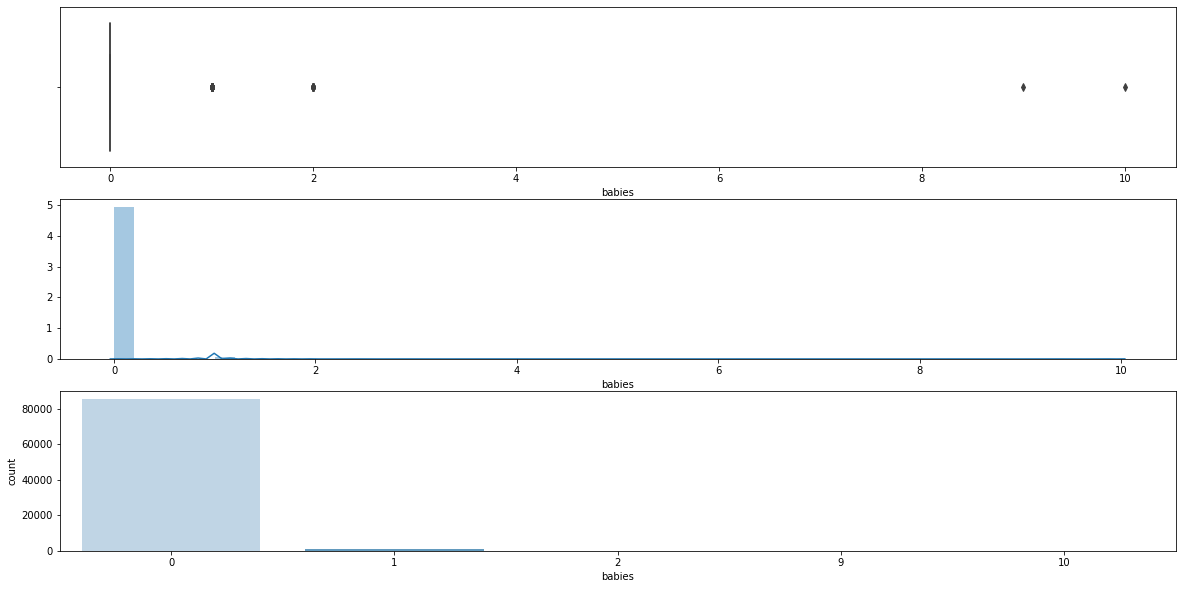

In [210]:
fig, axs = plt.subplots(3, figsize=(20,10))
sns.boxplot("babies", data=bookings_df, ax=axs[0]);
sns.distplot(bookings_df['babies'], ax=axs[1]);
sns.countplot(bookings_df['babies'], palette = sns.color_palette("Blues")[1::2], 
              order = bookings_df['babies'].value_counts().index, ax = axs[2]);

In [211]:
#occurrance of values
bookings_df.babies.value_counts()

0     85628
1       890
2        14
9         1
10        1
Name: babies, dtype: int64

In [212]:
#remove the outliers
bookings_df_no_outliers = bookings_df_no_outliers[bookings_df_no_outliers.babies < 2]

**`is_repeated_guest`**: Value indicating if the booking name was from a repeated guest (1) or not (0).

In [213]:
#number of unique values
bookings_df.is_repeated_guest.nunique()

2

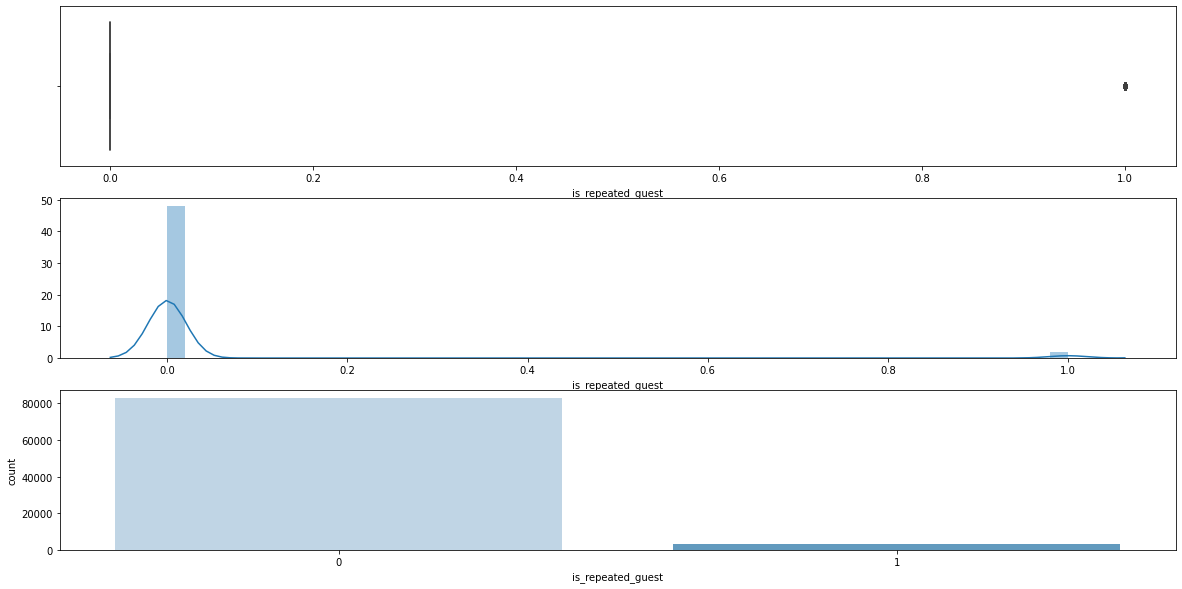

In [214]:
fig, axs = plt.subplots(3, figsize=(20,10))
sns.boxplot("is_repeated_guest", data=bookings_df, ax=axs[0]);
sns.distplot(bookings_df['is_repeated_guest'], ax=axs[1]);
sns.countplot(bookings_df['is_repeated_guest'], palette = sns.color_palette("Blues")[1::2], 
              order = bookings_df['is_repeated_guest'].value_counts().index, ax = axs[2]);

Evidently, the values are either 0 or 1, making this a categorical feature

In [215]:
#occurrance of values
bookings_df.is_repeated_guest.value_counts()

0    83175
1     3359
Name: is_repeated_guest, dtype: int64

**`previous_cancellations`**: Number of previous bookings that were canceled by the customer prior to the current booking.

In [216]:
#number of unique values
bookings_df.previous_cancellations.nunique()

15

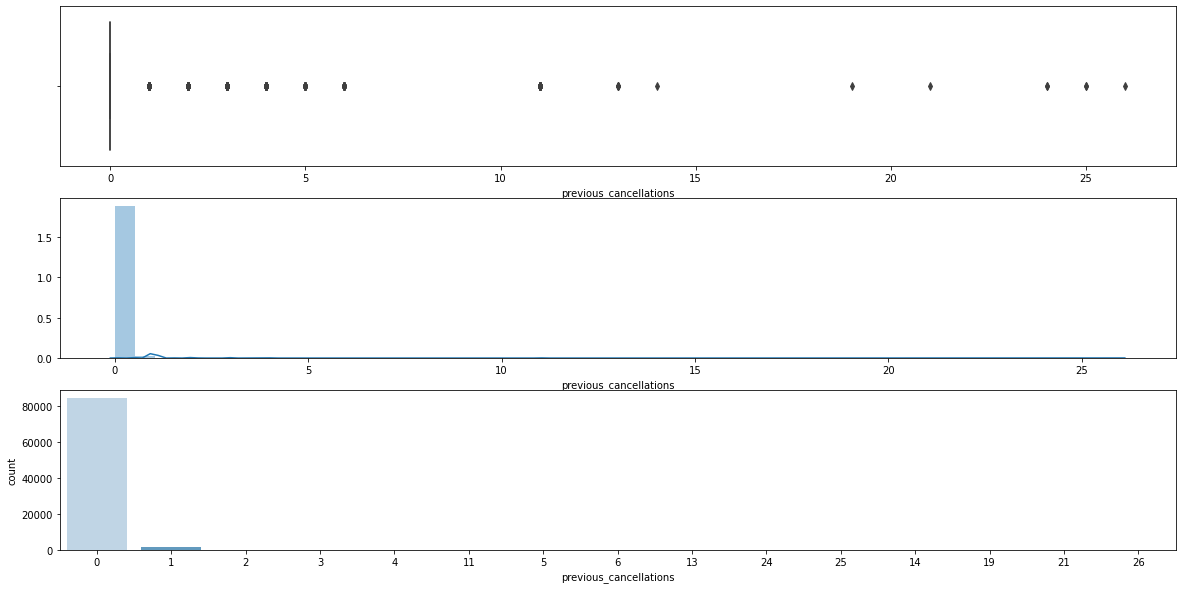

In [217]:
fig, axs = plt.subplots(3, figsize=(20,10))
sns.boxplot("previous_cancellations", data=bookings_df, ax=axs[0]);
sns.distplot(bookings_df['previous_cancellations'], ax=axs[1]);
sns.countplot(bookings_df['previous_cancellations'], palette = sns.color_palette("Blues")[1::2], 
              order = bookings_df['previous_cancellations'].value_counts().index, ax = axs[2]);

In [218]:
#5 most occurring values
bookings_df.previous_cancellations.value_counts().head()

0    84882
1     1379
2      107
3       61
4       30
Name: previous_cancellations, dtype: int64

In [219]:
#5 least occurring values
bookings_df.previous_cancellations.value_counts().tail()

25    2
14    1
19    1
21    1
26    1
Name: previous_cancellations, dtype: int64

In [220]:
#remove the outliers
bookings_df_no_outliers = bookings_df_no_outliers[bookings_df_no_outliers.previous_cancellations <= 4]

**`previous_bookings_not_canceled`**: Number of previous bookings not canceled by the customer prior to the current booking.

In [221]:
#number of unique values
bookings_df.previous_bookings_not_canceled.nunique()

73

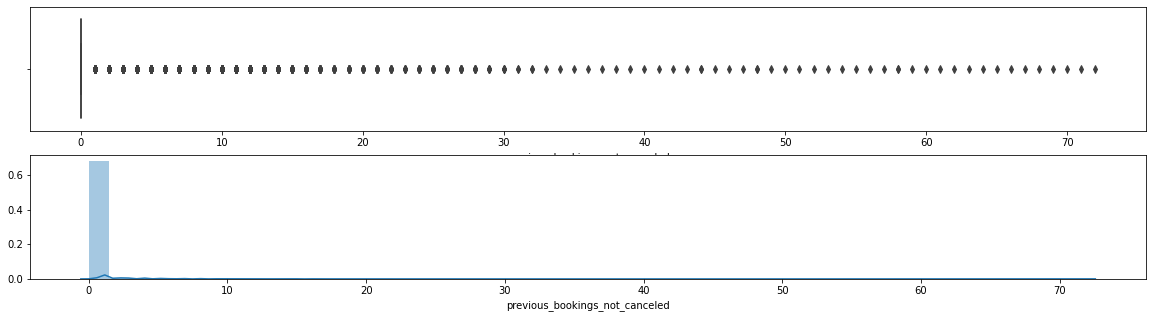

In [222]:
fig, axs = plt.subplots(2, figsize=(20,5))
sns.boxplot("previous_bookings_not_canceled", data=bookings_df, ax=axs[0]);
sns.distplot(bookings_df['previous_bookings_not_canceled'], ax=axs[1]);

In [223]:
#5 most occurring values
bookings_df.previous_bookings_not_canceled.value_counts().head()

0    83220
1     1387
2      536
3      299
4      208
Name: previous_bookings_not_canceled, dtype: int64

In [224]:
#5 least occurring values
bookings_df.previous_bookings_not_canceled.value_counts().tail()

38    1
39    1
71    1
41    1
63    1
Name: previous_bookings_not_canceled, dtype: int64

In [225]:
#remove the outliers
bookings_df_no_outliers = bookings_df_no_outliers[bookings_df_no_outliers.previous_bookings_not_canceled <= 10]

**`booking_changes`**: Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation.

In [226]:
#number of unique values
bookings_df.booking_changes.nunique()

19

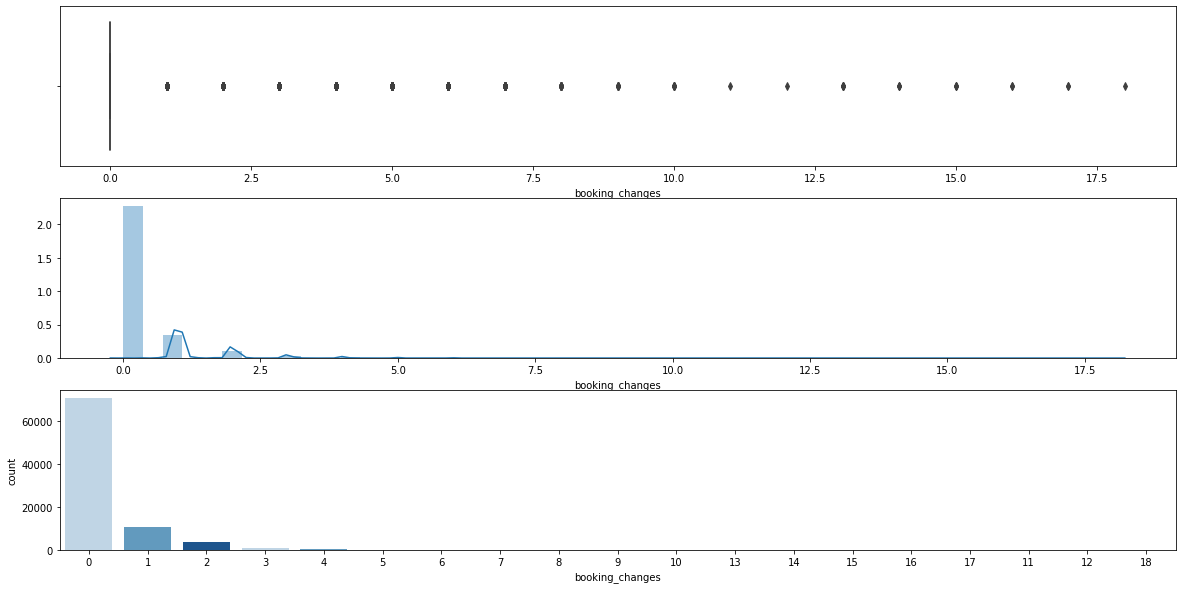

In [227]:
fig, axs = plt.subplots(3, figsize=(20,10))
sns.boxplot("booking_changes", data=bookings_df, ax=axs[0]);
sns.distplot(bookings_df['booking_changes'], ax=axs[1]);
sns.countplot(bookings_df['booking_changes'], palette = sns.color_palette("Blues")[1::2], 
              order = bookings_df['booking_changes'].value_counts().index, ax = axs[2]);

In [228]:
#5 most occurring values
bookings_df.booking_changes.value_counts().head()

0    70867
1    10760
2     3462
3      856
4      346
Name: booking_changes, dtype: int64

In [229]:
#5 least occurring values
bookings_df.booking_changes.value_counts().tail()

16    2
17    2
11    1
12    1
18    1
Name: booking_changes, dtype: int64

In [230]:
#remove the outliers
bookings_df_no_outliers = bookings_df_no_outliers[bookings_df_no_outliers.booking_changes <= 5]

**`days_in_waiting_list`**: Number of days the booking was on the waiting list before it was confirmed to the customer.

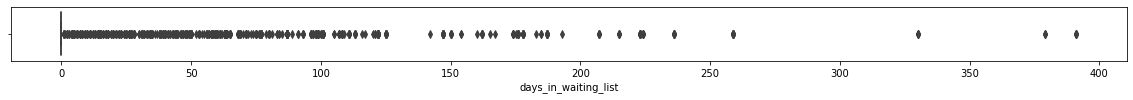

In [231]:
#distribution
plt.figure(figsize=(20,1))
sns.boxplot("days_in_waiting_list", data=bookings_df);

In [232]:
#number of unique values
bookings_df.days_in_waiting_list.nunique()

127

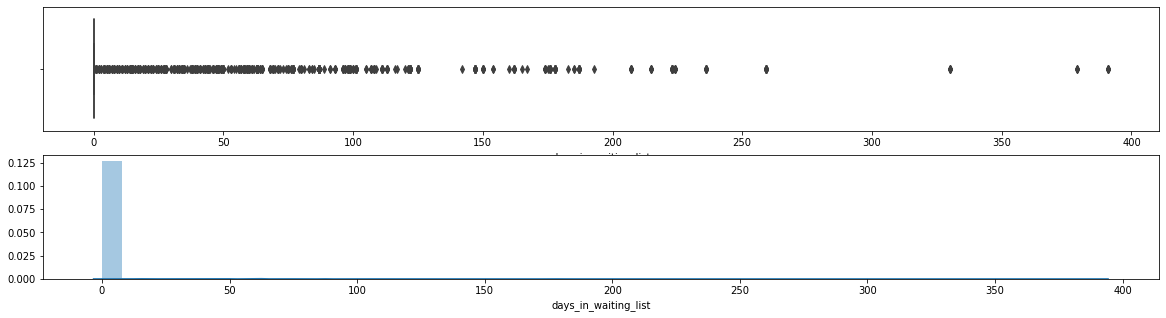

In [233]:
fig, axs = plt.subplots(2, figsize=(20,5))
sns.boxplot("days_in_waiting_list", data=bookings_df, ax=axs[0]);
sns.distplot(bookings_df['days_in_waiting_list'], ax=axs[1]);

In [234]:
#5 most occurring values
bookings_df.days_in_waiting_list.value_counts().head()

0     85679
63       53
87       25
44       23
15       22
Name: days_in_waiting_list, dtype: int64

In [235]:
#5 least occurring values
bookings_df.days_in_waiting_list.value_counts().tail()

45     1
109    1
175    1
70     1
165    1
Name: days_in_waiting_list, dtype: int64

In [236]:
#remove the outliers
bookings_df_no_outliers = bookings_df_no_outliers[bookings_df_no_outliers.days_in_waiting_list <= 100]

**`adr`**: Average Daily Rate as defined by dividing the sum of all lodging transactions by the total number of staying nights.

In [237]:
#number of unique values
bookings_df.adr.nunique()

8850

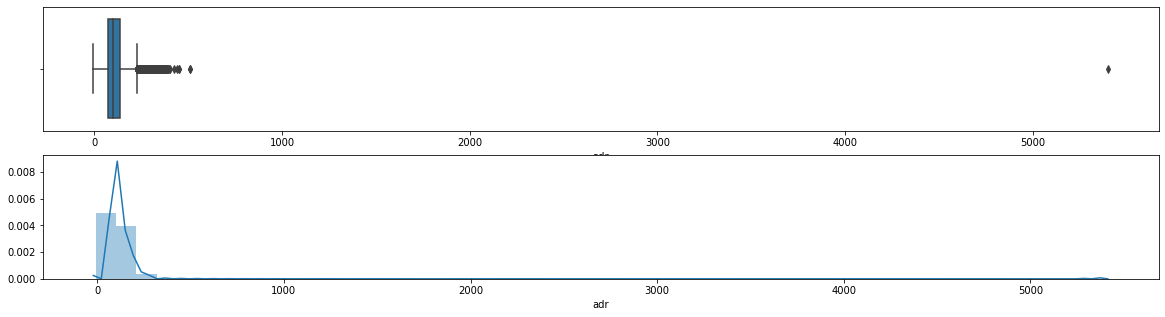

In [238]:
fig, axs = plt.subplots(2, figsize=(20,5))
sns.boxplot("adr", data=bookings_df, ax=axs[0]);
sns.distplot(bookings_df['adr'], ax=axs[1]);

In [239]:
#5 most occurring values
bookings_df.adr.value_counts().head()

0.0     1626
75.0    1314
65.0    1253
85.0     858
48.0     855
Name: adr, dtype: int64

In [240]:
#5 least occurring values
bookings_df.adr.value_counts().tail()

130.23    1
244.43    1
103.79    1
226.17    1
82.24     1
Name: adr, dtype: int64

In [241]:
#remove the outliers
Q1 = bookings_df['adr'].quantile(0.25)
Q3 = bookings_df['adr'].quantile(0.75)
IQR = Q3 - Q1 
bookings_df_no_outliers = bookings_df.loc[(bookings_df['adr'] >= Q1 - 1.5 * IQR)&(bookings_df['adr'] <= Q3 + 1.5 *IQR)]

**`required_car_parking_spaces`**: Number of car parking spaces required by the customer.

In [242]:
#number of unique values
bookings_df.required_car_parking_spaces.nunique()

5

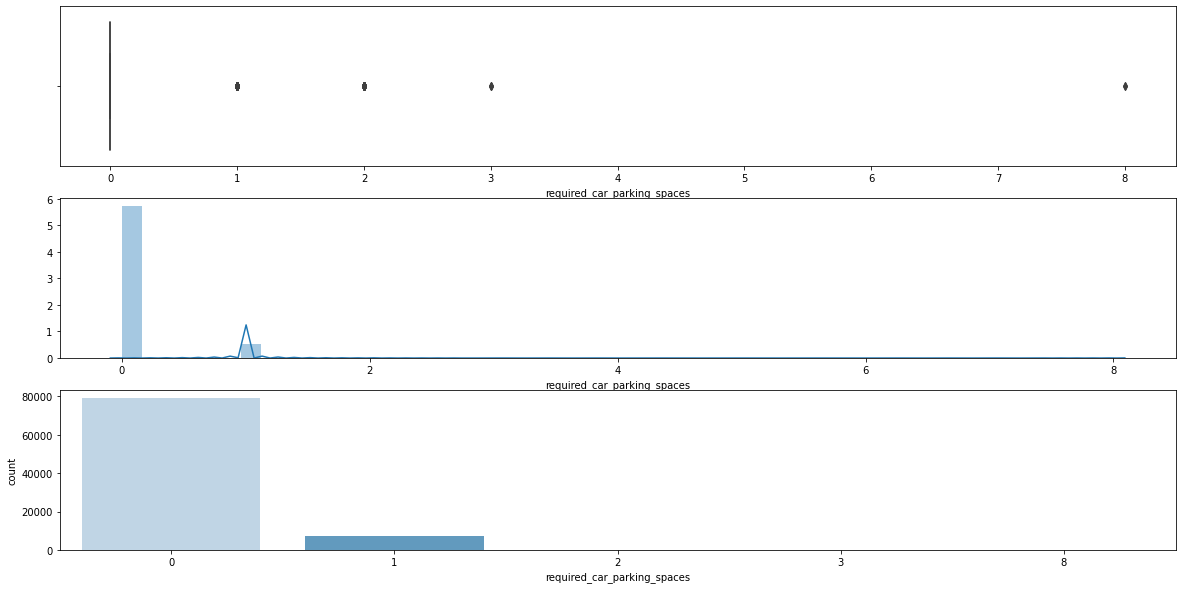

In [243]:
fig, axs = plt.subplots(3, figsize=(20,10))
sns.boxplot("required_car_parking_spaces", data=bookings_df, ax=axs[0]);
sns.distplot(bookings_df['required_car_parking_spaces'], ax=axs[1]);
sns.countplot(bookings_df['required_car_parking_spaces'], palette = sns.color_palette("Blues")[1::2], 
              order = bookings_df['required_car_parking_spaces'].value_counts().index, ax = axs[2]);

In [244]:
#occurrance of values
bookings_df.required_car_parking_spaces.value_counts()

0    79336
1     7165
2       28
3        3
8        2
Name: required_car_parking_spaces, dtype: int64

In [245]:
#remove the outliers
bookings_df_no_outliers = bookings_df_no_outliers[bookings_df_no_outliers.required_car_parking_spaces <= 2]

**`total_of_special_requests`**: Number of special requests made by the customer (e.g. twin bed or high floor).

In [246]:
#number of unique values
bookings_df.total_of_special_requests.nunique()

6

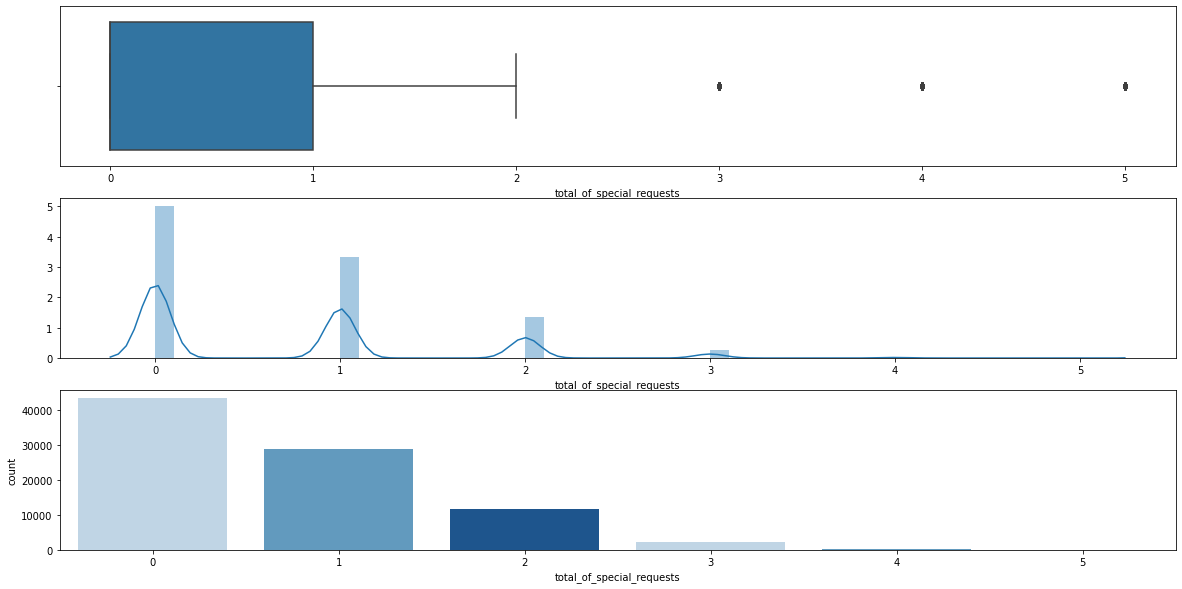

In [247]:
fig, axs = plt.subplots(3, figsize=(20,10))
sns.boxplot("total_of_special_requests", data=bookings_df, ax=axs[0]);
sns.distplot(bookings_df['total_of_special_requests'], ax=axs[1]);
sns.countplot(bookings_df['total_of_special_requests'], palette = sns.color_palette("Blues")[1::2], 
              order = bookings_df['total_of_special_requests'].value_counts().index, ax = axs[2]);

In [248]:
#occurrance of values
bookings_df.total_of_special_requests.value_counts()

0    43418
1    28766
2    11709
3     2290
4      317
5       34
Name: total_of_special_requests, dtype: int64

In [249]:
#remove the outliers
bookings_df_no_outliers = bookings_df_no_outliers[bookings_df_no_outliers.total_of_special_requests != 5]

**The categorical features**

In [250]:
cat_features = list(bookings_df.select_dtypes(include= ['object']).columns)
print(cat_features)

['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', 'reservation_status', 'reservation_status_date']


In [251]:
print('There are', len(cat_features),'categorical features')

There are 12 categorical features


**`hotel`**: Resort Hotel or City Hotel.

In [252]:
#number of unique values
bookings_df.hotel.nunique()

2

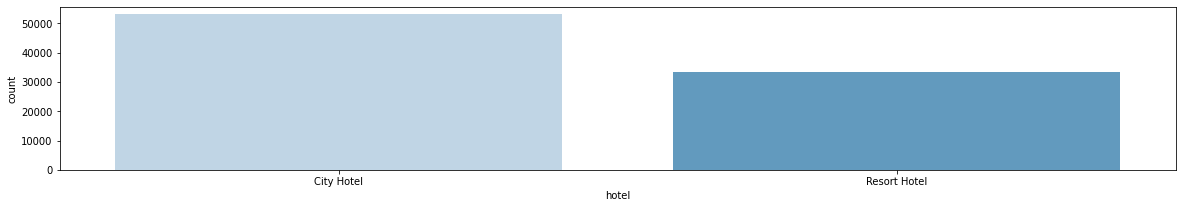

In [253]:
plt.figure(figsize=(20,3))
sns.countplot(bookings_df['hotel'], palette = sns.color_palette("Blues")[1::2], 
              order = bookings_df['hotel'].value_counts().index);

In [254]:
#occurrance of values
bookings_df.hotel.value_counts()

City Hotel      53034
Resort Hotel    33500
Name: hotel, dtype: int64

**`arrival_date_month`**: Month of arrival date.

In [255]:
#number of unique values
bookings_df.arrival_date_month.nunique()

12

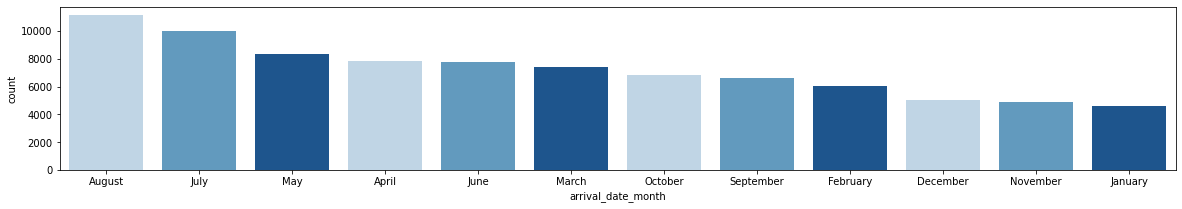

In [256]:
plt.figure(figsize=(20,3))
sns.countplot(bookings_df['arrival_date_month'], palette = sns.color_palette("Blues")[1::2], 
              order = bookings_df['arrival_date_month'].value_counts().index);

In [257]:
#5 most occurring values
bookings_df.arrival_date_month.value_counts().head()

August    11182
July       9974
May        8315
April      7841
June       7732
Name: arrival_date_month, dtype: int64

In [258]:
#5 least occurring values
bookings_df.arrival_date_month.value_counts().tail()

September    6638
February     6008
December     5039
November     4924
January      4610
Name: arrival_date_month, dtype: int64

**`meal`**: Type of meal booked. Categories are presented in standard hospitality meal packages: 
- Undefined/SC – no meal package
- BB – Bed & Breakfast
- HB – Half board (breakfast and one other meal – usually dinner)
- FB – Full board (breakfast, lunch, and dinner)

In [259]:
#number of unique values
bookings_df.meal.nunique()

5

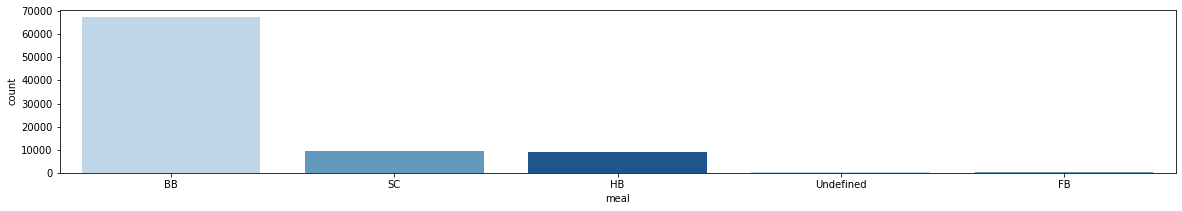

In [260]:
plt.figure(figsize=(20,3))
sns.countplot(bookings_df['meal'], palette = sns.color_palette("Blues")[1::2], 
              order = bookings_df['meal'].value_counts().index);

In [261]:
#occurrance of values
bookings_df.meal.value_counts()

BB           67256
SC            9386
HB            9045
Undefined      488
FB             359
Name: meal, dtype: int64

We will replace SC and Undefined (because they refer to the same thing) with 'No Meal'.

In [262]:
bookings_df.meal = bookings_df.meal.str.replace('SC','No Meal').str.replace('Undefined','No Meal')
bookings_df_no_outliers.meal = bookings_df_no_outliers.meal.str.replace('SC','No Meal').str\
                                                               .replace('Undefined','No Meal')

In [263]:
#remove the outliers
bookings_df_no_outliers = bookings_df_no_outliers[bookings_df_no_outliers['meal']
                                                  .map(bookings_df_no_outliers['meal'].value_counts()) >= 500]

**`country`**: Country of origin. Categories are represented in the ISO 3155–3:2013 format.

In [264]:
#number of unique values
bookings_df.country.nunique()

177

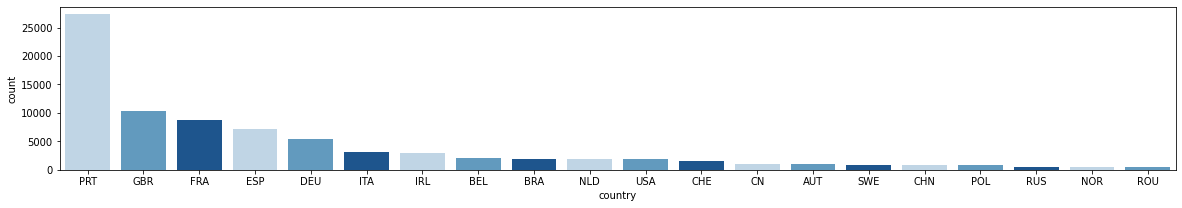

In [265]:
#Top 20
plt.figure(figsize=(20,3))
sns.countplot(bookings_df['country'], palette = sns.color_palette("Blues")[1::2], 
              order = bookings_df['country'].value_counts().index[:20]);

In [266]:
#5 most occurring values
bookings_df.country.value_counts().head()

PRT    27295
GBR    10407
FRA     8798
ESP     7228
DEU     5370
Name: country, dtype: int64

In [267]:
#5 least occurring values
bookings_df.country.value_counts().tail()

MLI    1
GUY    1
DMA    1
MMR    1
ASM    1
Name: country, dtype: int64

In [268]:
#remove the outliers
bookings_df_no_outliers = bookings_df_no_outliers[bookings_df_no_outliers['country']
                                                  .map(bookings_df_no_outliers['country'].value_counts()) >= 100]

Since the values of the countries are represented in an uninterpretable format, we decided to convert them into their actual names. To accomplish this, we had to scrape the data from Wikipedia.

In [269]:
page = requests.get('https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes')
soup = BeautifulSoup(page.content, "html.parser")

countries_data = []
for x in soup.find_all('table')[0].find_all('td'):
    if '– See' in x.text.strip(): #skip these because they were empty rows
        continue
    countries_data.append(x.text.strip())

In [270]:
countries_data[:10]

['Afghanistan',
 'The Islamic Republic of Afghanistan',
 'UN member state',
 '.mw-parser-output .monospaced{font-family:monospace,monospace}AF',
 'AFG',
 '004',
 'ISO 3166-2:AF',
 '.af',
 'Åland Islands',
 'Åland']

Now we just need to extract the country codes and their names.

In [271]:
#country codes
country_codes = countries_data[4::8]
print(country_codes[:10])

['AFG', 'ALA', 'ALB', 'DZA', 'ASM', 'AND', 'AGO', 'AIA', 'ATA', 'ATG']


In [272]:
#country names
country_names = countries_data[::8]
print(country_names[:10])

['Afghanistan', 'Åland Islands', 'Albania', 'Algeria', 'American Samoa', 'Andorra', 'Angola', 'Anguilla', 'Antarctica\u200a[a]', 'Antigua and Barbuda']


In [273]:
clean_country_names = []
for c in country_names:
    c = c.replace('\xa0',' ')
    name = re.sub(r'\([^)]*\)', '', c) #this removes () and everything in between
    name2 = re.sub(r'\[.*\]', '', name) #this removes [] and everything in between
    if ',' in name2: #ex: 'Tanzania, the United Republic of', we only want the first part
        clean_country_names.append(name2.split(',')[0].strip()) 
    else:
        clean_country_names.append(name2.strip())

In [274]:
#replacing the codes with the names of the countries
for i in range(len(country_codes)):
    bookings_df.country = bookings_df.country.str.replace(country_codes[i], clean_country_names[i])
    bookings_df_no_outliers.country = bookings_df_no_outliers.country.str.replace(country_codes[i], 
                                                                                  clean_country_names[i])

**`market_segment`**: Market segment designation. In categories, the term “TA” means “Travel Agents” and “TO” means “Tour Operators”.

In [275]:
#number of unique values
bookings_df.market_segment.nunique()

7

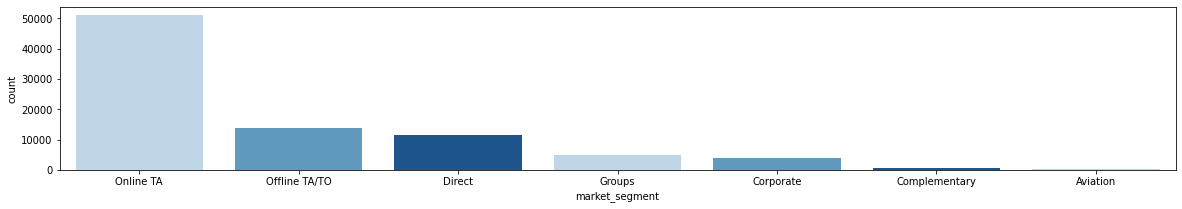

In [276]:
plt.figure(figsize=(20,3))
sns.countplot(bookings_df['market_segment'], palette = sns.color_palette("Blues")[1::2], 
              order = bookings_df['market_segment'].value_counts().index);

In [277]:
#occurrance of values
bookings_df.market_segment.value_counts()

Online TA        51286
Offline TA/TO    13814
Direct           11592
Groups            4916
Corporate         4014
Complementary      686
Aviation           226
Name: market_segment, dtype: int64

In [278]:
#remove the outliers
bookings_df_no_outliers = bookings_df_no_outliers[bookings_df_no_outliers['market_segment']
                                                .map(bookings_df_no_outliers['market_segment'].value_counts()) >= 1000]

**`distribution_channel`**: Booking distribution channel. The term “TA” means “Travel Agents” and “TO” means “Tour Operators”.

In [279]:
#number of unique values
bookings_df.distribution_channel.nunique()

5

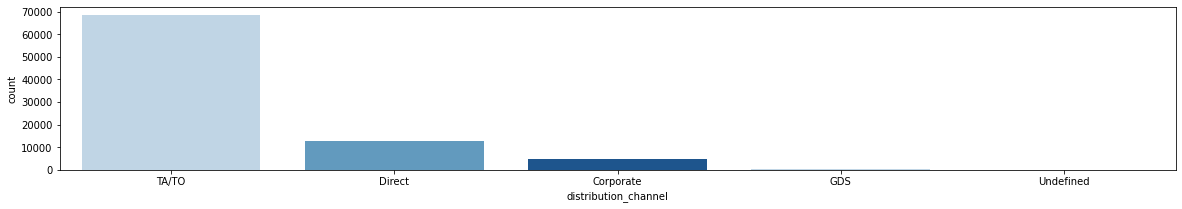

In [280]:
plt.figure(figsize=(20,3))
sns.countplot(bookings_df['distribution_channel'], palette = sns.color_palette("Blues")[1::2], 
              order = bookings_df['distribution_channel'].value_counts().index);

In [281]:
#occurrance of values
bookings_df.distribution_channel.value_counts()

TA/TO        68713
Direct       12759
Corporate     4880
GDS            181
Undefined        1
Name: distribution_channel, dtype: int64

In [282]:
#remove the outliers 
bookings_df_no_outliers = bookings_df_no_outliers[bookings_df_no_outliers['distribution_channel']
                                        .map(bookings_df_no_outliers['distribution_channel'].value_counts()) >= 1000]

**`reserved_room_type`**: Code of room type reserved. Code is presented instead of designation for anonymity reasons.

In [283]:
#number of unique values
bookings_df.reserved_room_type.nunique()

9

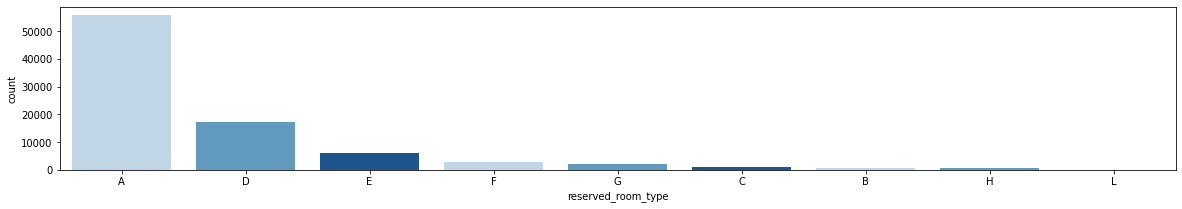

In [284]:
plt.figure(figsize=(20,3))
sns.countplot(bookings_df['reserved_room_type'], palette = sns.color_palette("Blues")[1::2], 
              order = bookings_df['reserved_room_type'].value_counts().index);

In [285]:
#occurrance of values
bookings_df.reserved_room_type.value_counts()

A    56041
D    17347
E     5995
F     2811
G     2038
C      913
B      787
H      596
L        6
Name: reserved_room_type, dtype: int64

In [286]:
#remove the outliers
bookings_df_no_outliers = bookings_df_no_outliers[bookings_df_no_outliers['reserved_room_type']
                                        .map(bookings_df_no_outliers['reserved_room_type'].value_counts()) >= 1000]

**`assigned_room_type`**: Code for the type of room assigned to the booking. Sometimes the assigned room type differs from the reserved room type due to hotel operation reasons (e.g. overbooking) or by customer request. Code is presented instead of designation for anonymity reasons.

In [287]:
#number of unique values
bookings_df.assigned_room_type.nunique()

11

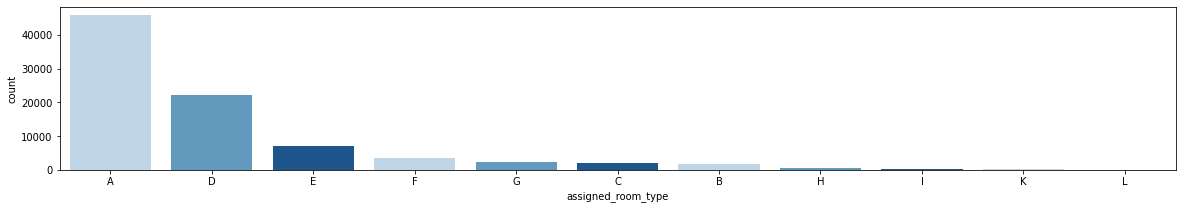

In [288]:
plt.figure(figsize=(20,3))
sns.countplot(bookings_df['assigned_room_type'], palette = sns.color_palette("Blues")[1::2], 
              order = bookings_df['assigned_room_type'].value_counts().index);

In [289]:
#occurrance of values
bookings_df.assigned_room_type.value_counts()

A    46065
D    22259
E     7121
F     3607
G     2480
C     2139
B     1628
H      702
I      347
K      185
L        1
Name: assigned_room_type, dtype: int64

In [290]:
#remove the outliers
bookings_df_no_outliers = bookings_df_no_outliers[bookings_df_no_outliers['assigned_room_type']
                                        .map(bookings_df_no_outliers['assigned_room_type'].value_counts()) >= 1000]

**`deposit_type`**: Indication on if the customer deposited to guarantee the booking. This variable can assume three categories: 
- No Deposit – no deposit was made
- Non Refund – a deposit was made in the value of the total stay cost
- Refundable – a deposit was made with a value under the total cost of the stay 


In [291]:
#number of unique values
bookings_df.deposit_type.nunique()

3

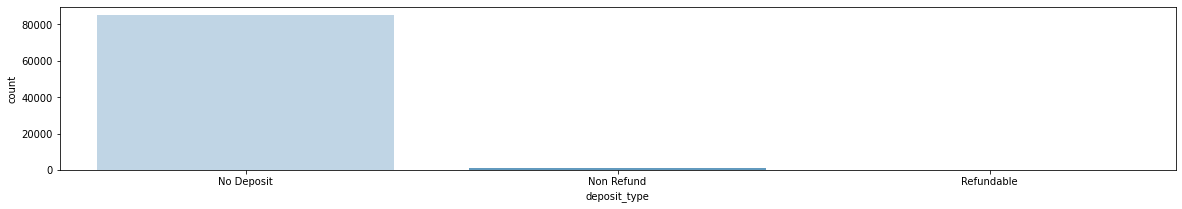

In [292]:
plt.figure(figsize=(20,3))
sns.countplot(bookings_df['deposit_type'], palette = sns.color_palette("Blues")[1::2], 
              order = bookings_df['deposit_type'].value_counts().index);

In [293]:
#occurrance of values
bookings_df.deposit_type.value_counts()

No Deposit    85390
Non Refund     1037
Refundable      107
Name: deposit_type, dtype: int64

**`customer_type`**: Type of booking, assuming one of four categories: 
- Contract – when the booking has an allotment or other type of contract associated with it
- Group – when the booking is associated with a group
- Transient – when the booking is not part of a group or contract and is not associated with another transient booking
- Transient-party – when the booking is transient but is associated with at least another transient booking

In [294]:
#number of unique values
bookings_df.customer_type.nunique()

4

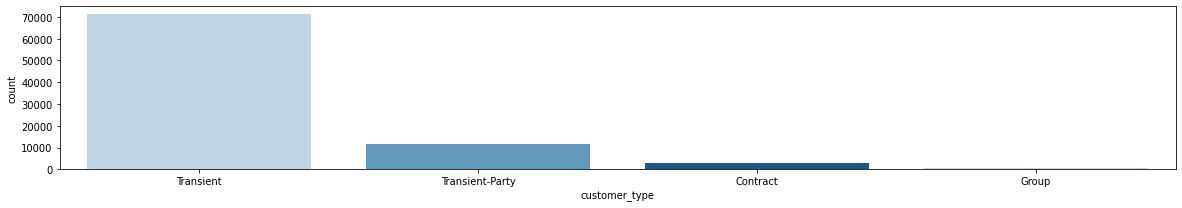

In [295]:
plt.figure(figsize=(20,3))
sns.countplot(bookings_df['customer_type'], palette = sns.color_palette("Blues")[1::2], 
              order = bookings_df['customer_type'].value_counts().index);

In [296]:
#occurrance of values
bookings_df.customer_type.value_counts()

Transient          71298
Transient-Party    11568
Contract            3134
Group                534
Name: customer_type, dtype: int64

In [297]:
#remove the outliers
bookings_df_no_outliers = bookings_df_no_outliers[bookings_df_no_outliers['customer_type']
                                            .map(bookings_df_no_outliers['customer_type'].value_counts()) >= 1000]

**`reservation_status`**: Reservation’s last status, assuming one of three categories: 
- Canceled – booking was canceled by the customer
- Check-Out – customer has checked in but already departed
- No-Show – the customer did not check-in and did inform the hotel of the reason why

In [298]:
#number of unique values
bookings_df.reservation_status.nunique()

3

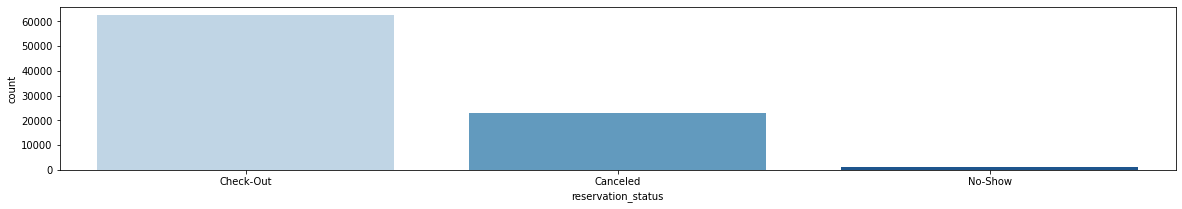

In [299]:
plt.figure(figsize=(20,3))
sns.countplot(bookings_df['reservation_status'], palette = sns.color_palette("Blues")[1::2], 
              order = bookings_df['reservation_status'].value_counts().index);

In [300]:
#occurrance of values
bookings_df.reservation_status.value_counts()

Check-Out    62643
Canceled     22885
No-Show       1006
Name: reservation_status, dtype: int64

This feature has direct relation with our target, as in it tells us if the booking was canceled, therefore, it should be dropped.

In [301]:
bookings_df.drop(columns=['reservation_status'], inplace=True)
bookings_df_no_outliers.drop(columns=['reservation_status'], inplace=True)

**`reservation_status_date`**: Date at which the last status was set.

In [302]:
#number of unique values
bookings_df.reservation_status_date.nunique()

926

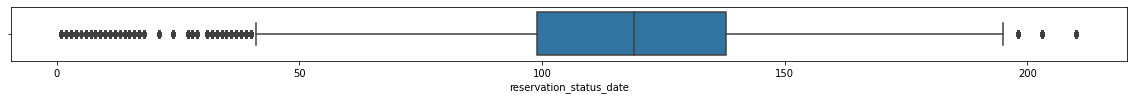

In [303]:
#distribution
plt.figure(figsize=(20,1))
sns.boxplot("reservation_status_date", data= pd.DataFrame(bookings_df['reservation_status_date']
                                                        .map(bookings_df['reservation_status_date'].value_counts())));

Since there are too many unique values, we decided to just extract the month and year

**`reservation_status_month`**: Month at which the last status was set.

In [304]:
bookings_df['reservation_status_month'] = pd.DatetimeIndex(bookings_df['reservation_status_date']).month
bookings_df_no_outliers['reservation_status_month'] = pd.DatetimeIndex(bookings_df_no_outliers
                                                                       ['reservation_status_date']).month

In [305]:
#number of unique values
bookings_df.reservation_status_month.nunique()

12

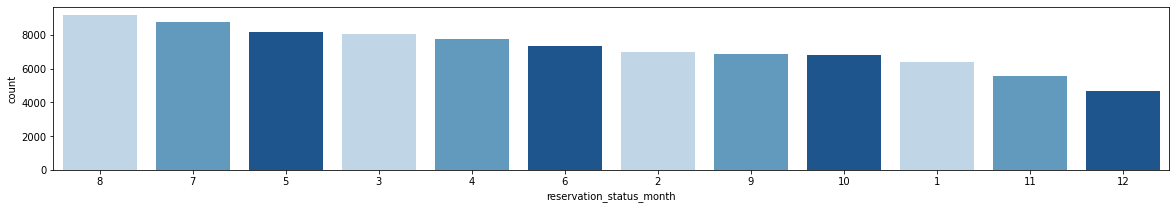

In [306]:
plt.figure(figsize=(20,3))
sns.countplot(bookings_df['reservation_status_month'], palette = sns.color_palette("Blues")[1::2], 
              order = bookings_df['reservation_status_month'].value_counts().index);

In [307]:
#5 most occurring values
bookings_df.reservation_status_month.value_counts().head()

8    9200
7    8766
5    8160
3    8069
4    7771
Name: reservation_status_month, dtype: int64

In [308]:
#5 least occurring values
bookings_df.reservation_status_month.value_counts().tail()

9     6855
10    6783
1     6390
11    5556
12    4698
Name: reservation_status_month, dtype: int64

**`reservation_status_year`**: Year at which the last status was set.

In [309]:
bookings_df['reservation_status_year'] = pd.DatetimeIndex(bookings_df['reservation_status_date']).year
bookings_df_no_outliers['reservation_status_year'] = pd.DatetimeIndex(bookings_df_no_outliers
                                                                      ['reservation_status_date']).year

In [310]:
#number of unique values
bookings_df.reservation_status_year.nunique()

4

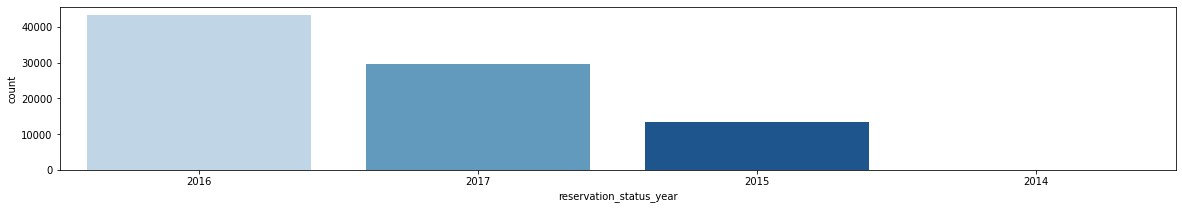

In [311]:
plt.figure(figsize=(20,3))
sns.countplot(bookings_df['reservation_status_year'], palette = sns.color_palette("Blues")[1::2], 
              order = bookings_df['reservation_status_year'].value_counts().index);

In [312]:
#occurrance of values
bookings_df.reservation_status_year.value_counts()

2016    43421
2017    29717
2015    13384
2014       12
Name: reservation_status_year, dtype: int64

In [313]:
#remove the outliers
bookings_df_no_outliers = bookings_df_no_outliers[bookings_df_no_outliers['reservation_status_year'] != 2014]

In [314]:
#since we extracted the month and year, we no longer need this feature
bookings_df.drop(columns=['reservation_status_date'], inplace=True)
bookings_df_no_outliers.drop(columns=['reservation_status_date'], inplace=True)

In [315]:
#reseting the index
bookings_df.reset_index(drop=True, inplace=True)
bookings_df_no_outliers.reset_index(drop=True, inplace=True)

**The target feature**

**`is_canceled`**: Value indicating if the booking was canceled (1) or not (0).

In [316]:
#clean data
target_counts = bookings_df.is_canceled.value_counts()
print('There are',target_counts[1],'positive observations and',target_counts[0],'negative observations')

pos = target_counts[1] / (target_counts[0]+target_counts[1]) * 100
print(f'Percentage of the positive observations:{pos:.2f}%')

neg = target_counts[0] / (target_counts[0]+target_counts[1]) * 100
print(f'Percentage of the positive observations:{neg:.2f}%')

There are 23891 positive observations and 62643 negative observations
Percentage of the positive observations:27.61%
Percentage of the positive observations:72.39%


In [317]:
#clean data with no outliers
target_counts_no_outliers = bookings_df_no_outliers.is_canceled.value_counts()
print('There are',target_counts_no_outliers[1],'positive observations and',
      target_counts_no_outliers[0],'negative observations')

pos = target_counts_no_outliers[1] / (target_counts_no_outliers[0]+target_counts_no_outliers[1]) * 100
print(f'Percentage of the positive observations:{pos:.2f}%')

neg = target_counts_no_outliers[0] / (target_counts_no_outliers[0]+target_counts_no_outliers[1]) * 100
print(f'Percentage of the positive observations:{neg:.2f}%')

There are 21262 positive observations and 55324 negative observations
Percentage of the positive observations:27.76%
Percentage of the positive observations:72.24%


In [318]:
#saving the clean data
bookings_df.to_csv('hotel_bookings_clean.csv', index=False)
bookings_df_no_outliers.to_csv('hotel_bookings_clean_no_outliers.csv', index=False)